## Imports

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import random
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
# from matplotlib import animation
# from JSAnimation.IPython_display import display_animation
# import gym
import scipy.stats as stats
from scipy.stats import norm
from collections import namedtuple
import statistics
import time
import os
from collections import deque
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

import yfinance as yf
import datetime as dt

import pickle

import import_ipynb
import Generate_Data
import Environment

/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100

## Defining Model Classes
- Environment: Simulates the trading environment, handling state transitions, reward calculation, and interaction with the stock and option data.

- NeuralNet: Defines a simple feed-forward neural network used as the core model in the reinforcement learning agent.

- BrainDQN: Implements the DQN agent's logic, including policy selection, experience replay, epsilon-greedy action selection, and network updates.

- ReplayMemory: Manages the experience replay memory, storing agent experiences and sampling them for training.

- AgentActionValueBase: Provides the agent interface for interacting with BrainDQN, including action selection, memory storage, and updating the model.


In [2]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [3]:
class BrainDQN:
    def __init__(self, state_size, action_size, hidden_size=64, 
                 memory_size=10000, batch_size=64, gamma=0.99, 
                 learning_rate=1e-3, epsilon_start=1.0, epsilon_end=0.01, 
                 epsilon_decay=0.995, target_update=10):

        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update
        self.steps_done = 0

        # Initialize the policy network and the target network
        self.policy_net = NeuralNet(state_size, action_size, hidden_size)
        self.target_net = NeuralNet(state_size, action_size, hidden_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

        # Loss function
        self.loss_fn = nn.MSELoss()

    def decide_action(self, state, step=0, episode=0):
        """
        Decide on an action based on the current state using an epsilon-greedy policy.

        Parameters:
        - state: The current state.
        - step: The current step number (for tracking).
        - episode: The current episode number (for tracking).

        Returns:
        - action: The action to take.
        """
        # Update epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.steps_done += 1

        if random.random() < self.epsilon:
            # Take a random action
            action = random.randrange(self.action_size)
        else:
            # Use the policy network to select action
            state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            action = q_values.argmax().item()

        return action

    def memorize(self, state, action, next_state, reward):
        """
        Store experience in replay memory.

        Parameters:
        - state: The current state.
        - action: The action taken.
        - next_state: The next state after the action.
        - reward: The reward received after the action.
        """
        self.memory.append((state, action, next_state, reward))

    def update_agent(self):
        """
        Update the agent's neural network using experiences from memory.
        """
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch of experiences
        batch = random.sample(self.memory, self.batch_size)
        # Separate the batch into individual components
        states, actions, next_states, rewards = zip(*batch)

        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)  # Actions need to be a column vector
        next_states = torch.FloatTensor(next_states)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)  # Rewards need to be a column vector

        # Compute Q(s,a) using the policy network
        q_values = self.policy_net(states).gather(1, actions)

        # Compute max_a' Q(s', a') using the target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)

        # Compute target Q-values
        target_q_values = rewards + (self.gamma * next_q_values)

        # Compute loss
        loss = self.loss_fn(q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update the target network periodically
        if self.steps_done % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


In [4]:
class ReplayMemory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
    
    def push(self, state, action, state_next, reward):
        self.memory.append((state, action, state_next, reward))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [5]:
class AgentActionValueBase:
    def __init__(self, brain):
        self.brain = brain

    def get_action(self, state, step=0, episode=0):
        return self.brain.decide_action(state, step=step, episode=episode)

    def memorize(self, state, action, state_next, reward):
        self.brain.memorize(state, action, state_next, reward)

    def update_agent(self):
        self.brain.update_agent()

## Model Training

In [6]:
def train_agent(env, agent, num_episodes=1000, num_steps=30, gamma=0.99):
    """
    Trains the agent in the given environment.

    Parameters:
    - env: The trading environment (DeltaHedgingEnv).
    - agent: The RL agent (AgentActionValueBase).
    - num_episodes: The number of training episodes.
    - num_steps: The number of steps per episode.
    - gamma: Discount factor for future rewards.

    Returns:
    - pl_history: A list containing the P&L history for each episode.
    - reward_history: A list containing the cumulative reward history for each episode.
    """
    
    pl_history = []  # Profit and loss history for each episode
    reward_history = []  # Total reward history for each episode
    std_pl_history = []  # Standard deviation of P&L for each episode ; added this 

    last_30_pl = []
    
    for episode in range(num_episodes):
        state = env.reset()  # Reset the environment and get the initial state
        total_reward = 0  # Track total reward for the episode
        pl_episode = []  # Track portfolio value (P&L) for the episode

        for step in range(num_steps):
            # Agent takes an action based on the current state
            action = agent.get_action(state, step=step, episode=episode)
            
            # Environment returns the next state, reward, and whether the episode is done
            next_state, reward, done, pv = env.step(action)
            
            # Accumulate total reward, discounted by gamma (for future rewards)
            total_reward += reward * (gamma ** step)
            
            # Store the portfolio value (P&L) for the step
            pl_episode.append(pv)
            
            # Memorize the experience
            agent.memorize(state, action, next_state, reward)
            
            # Update the agent
            agent.update_agent()

            # Move to the next state
            state = next_state
            
            # If the episode is done, break out of the loop
            if done:
                break
        
        # At the end of the episode, calculate the total P&L and reward
        pl_total = sum(pl_episode)
        pl_history.append(pl_total)
        reward_history.append(total_reward)
        #std_pl_history.append(np.std(pl_episode))

        last_30_pl.append(pl_total)
        if len(last_30_pl) > 30:
            last_30_pl.pop(0)

        if episode >= 30:
            std = np.std(last_30_pl)
            std_pl_history.append(std)
        else:
            std_pl_history.append(np.nan)

        # if episode % 30 == 0 and episode != 0:
        #     std_pl_history.append(np.std(pl_episode[-30:]))  # Compute std dev of P&L for the episode # added this
        
        # Print progress every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}, P&L: {pl_total}, Std Dev P&L: {std_pl_history[-1:]}") # added std dev part
    
    return pl_history, reward_history, std_pl_history # added std dev

Episode 0/1000, Total Reward: -3960.6232897329014, P&L: -14.602279663085938


/var/folders/hz/cptf1fsx30vfjg68b57f0w4h0000gn/T/ipykernel_87437/3281257587.py:85: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states)


Episode 100/1000, Total Reward: -761504.8572997077, P&L: 146.08001708984375
Episode 200/1000, Total Reward: -165824.8504712039, P&L: 100.17013549804688
Episode 300/1000, Total Reward: -2799.4711912430826, P&L: -2.8654098510742188
Episode 400/1000, Total Reward: -551.168142392467, P&L: 3.7700653076171875
Episode 500/1000, Total Reward: -2902.0998953323246, P&L: -2.3223876953125
Episode 600/1000, Total Reward: -601379.3935865357, P&L: 727.9342651367188
Episode 700/1000, Total Reward: -47025.979178557965, P&L: -43.408203125
Episode 800/1000, Total Reward: -42643.16359367722, P&L: -79.99763488769531
Episode 900/1000, Total Reward: -49553.30760171247, P&L: 16.141510009765625


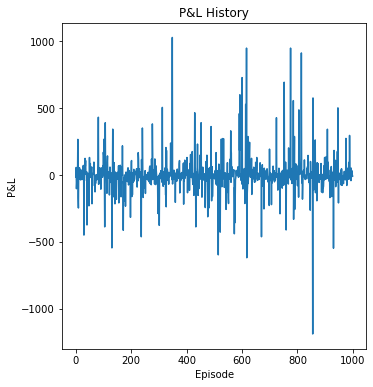

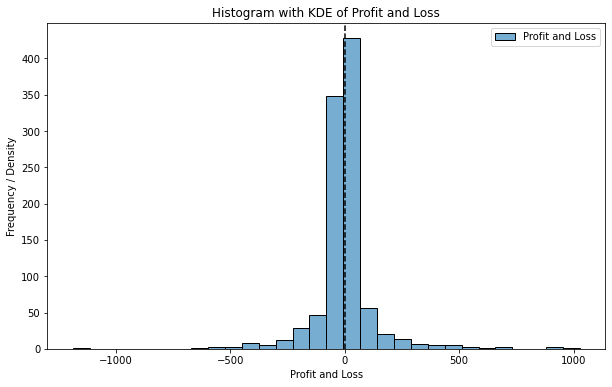

In [7]:
##Getting train datasets
features_train = Generate_Data.features_train
df_stock_train = Generate_Data.df_stock_train
call_options_train = Generate_Data.call_options_train

# Set up your environment with real AAPL stock and option data
env_train = Environment.Environment(
    stock_data=df_stock_train,
    option_data=call_options_train,
    features_data=features_train,
    T=30,
    n_steps=30,
    num_sold_opt=100,
    kappa=0.1,
    alpha=0.001
)
num_states = env_train.num_states
num_actions = env_train.num_actions

# Initialize the agent's brain
brain = BrainDQN(num_states, num_actions)

# Initialize the agent
dqn_agent = AgentActionValueBase(brain)

# Train the agent
pl_history, reward_history, std_pl = train_agent(env_train, dqn_agent, num_episodes=1000, num_steps=30)

plt.figure(figsize=(12, 6))

# Plot P&L history
plt.subplot(1, 2, 1)
plt.plot(pl_history)
plt.title("P&L History")
plt.xlabel("Episode")
plt.ylabel("P&L")

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(pl_history, kde=False, bins=30, label="Profit and Loss", alpha=0.6)

plt.axvline(0, color='k', linestyle='--')  # Mark zero for reference
plt.xlabel("Profit and Loss")
plt.ylabel("Frequency / Density")
plt.title("Histogram with KDE of Profit and Loss")
plt.legend()
plt.show()

plt.show()

In [23]:
# def save_brain(brain, filepath):
#     """
#     Saves the BrainDQN model's policy network and relevant hyperparameters.
#     """
#     torch.save({
#         'policy_net_state_dict': brain.policy_net.state_dict(),
#         'target_net_state_dict': brain.target_net.state_dict(),
#         'epsilon': brain.epsilon,
#         'steps_done': brain.steps_done,
#         'hyperparameters': {
#             'state_size': brain.state_size,
#             'action_size': brain.action_size,
#             'hidden_size': brain.hidden_size,
#             'gamma': brain.gamma,
#             'learning_rate': brain.learning_rate,
#             'epsilon_min': brain.epsilon_min,
#             'epsilon_decay': brain.epsilon_decay,
#             'target_update': brain.target_update
#         }
#     }, filepath)

# # Usage
# save_brain(brain, "models/dqn_trained_brain.pth")


In [8]:
# Save the agent (if additional attributes need to be saved)
with open("models/dqn_trained_agent.pkl", "wb") as f:
    pickle.dump(dqn_agent, f)

## Notebook Summary
Train DQN model, save as dqn_trained_brain